In [1]:
import kagglehub
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam


import matplotlib.pyplot as plt

import random

/Users/maxfrischknecht/.pyenv/versions/3.11.5/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Download dataset from Kaggle


In [6]:
# This gets saved locally on your machine, check the path for the location
path = kagglehub.dataset_download("tarundalal/anime-quotes")
print("Path to dataset files:", path)


Path to dataset files: /Users/maxfrischknecht/.cache/kagglehub/datasets/tarundalal/anime-quotes/versions/1


## 2. Load the dataset with a given filename


In [7]:
filename = "AnimeQuotes.csv"  # Specify the filename here
dataset_path = os.path.join(path, filename)

if os.path.exists(dataset_path):
    df = pd.read_csv(dataset_path)
    print("Dataset loaded successfully:")
    print(df.head())
else:
    raise FileNotFoundError(f"File {filename} not found in the dataset directory.")


Dataset loaded successfully:
                                               Quote         Character  \
0  People’s lives don’t end when they die, it end...     Itachi Uchiha   
1  If you don’t take risks, you can’t create a fu...    Monkey D Luffy   
2   If you don’t like your destiny, don’t accept it.    Naruto Uzumaki   
3       When you give up, that’s when the game ends.  Mitsuyoshi Anzai   
4  All we can do is live until the day we die. Co...      Deneil Young   

                             Anime  
0                           Naruto  
1                        One Piece  
2                           Naruto  
3                        Slam Dunk  
4  Uchuu Kyoudai or Space Brothers  


## 3. Extract quotes and preprocess text


In [8]:
# Extract the "Quote" column from the DataFrame
quotes = df['Quote']

# Convert all values in the column to strings (in case they are not already)
quotes = quotes.astype(str)

# Convert the column into a Python list (so it can be processed further)
quotes = quotes.tolist()

quotes

['People’s lives don’t end when they die, it ends when they lose faith.',
 'If you don’t take risks, you can’t create a future!',
 'If you don’t like your destiny, don’t accept it.',
 'When you give up, that’s when the game ends.',
 'All we can do is live until the day we die. Control what we can…and fly free.',
 'Forgetting is like a wound. The wound may heal, but it has already left a scar.',
 'It’s just pathetic to give up on something before you even give it a shot.”',
 'If you don’t share someone’s pain, you can never understand them.',
 'Whatever you lose, you’ll find it again. But what you throw away you’ll never get back.',
 'We don’t have to know what tomorrow holds! That’s why we can live for everything we’re worth today!”',
 'Why should I apologize for being a monster? Has anyone ever apologized for turning me into one?',
 'People become stronger because they have memories they can’t forget.',
 'I’ll leave tomorrow’s problems to tomorrow’s me.',
 'If you wanna make people dr

## 4. Tokenize the text data


In [9]:
# Create a tokenizer object to process the text
# This object will be used to convert words into numerical values (tokens).
tokenizer = Tokenizer() # num_words=5000 limit to improve model based on low learning performance

# Fit the tokenizer on the list of quotes
# This builds a vocabulary based on the words in the quotes dataset
# Counts the frequency of each word in the dataset.
# Assigns a unique index to each word.
tokenizer.fit_on_texts(quotes)

# Converts each quote into a sequence of numbers based on the learned word indices.
sequences = tokenizer.texts_to_sequences(quotes)
sequences[:1]

[[306, 307, 18, 101, 28, 32, 61, 5, 141, 28, 32, 55, 308]]

In [10]:
# check how many words we have in the data set. 
len(tokenizer.word_index)

634

## 5. Create input-output pairs for training


In machine learning, especially in sequence models, we train a model using input-output pairs where:
- The input is a partial sequence of words.
- The output is the next word that the model should predict.
- This code creates input-output pairs for training the text generation model using n-gram-like sequences.
- It progressively increases the sequence length so that the model learns contextual relationships between words.
- It helps the model predict the next word in a sequence.


```py
[10, 15]            # "The power"
[10, 15, 22]        # "The power is"
[10, 15, 22, 8]     # "The power is strong"
```

In [11]:
# Initialize an empty list to store input sequences
input_sequences = []

# Loop through each tokenized sequence (each quote in numerical format)
for seq in sequences:
    # Generate progressively growing sub-sequences from each full sequence
    for i in range(1, len(seq)):  
        # Append a sub-sequence that starts from the first word up to the i-th word
        input_sequences.append(seq[:i+1])

input_sequences

[[306, 307],
 [306, 307, 18],
 [306, 307, 18, 101],
 [306, 307, 18, 101, 28],
 [306, 307, 18, 101, 28, 32],
 [306, 307, 18, 101, 28, 32, 61],
 [306, 307, 18, 101, 28, 32, 61, 5],
 [306, 307, 18, 101, 28, 32, 61, 5, 141],
 [306, 307, 18, 101, 28, 32, 61, 5, 141, 28],
 [306, 307, 18, 101, 28, 32, 61, 5, 141, 28, 32],
 [306, 307, 18, 101, 28, 32, 61, 5, 141, 28, 32, 55],
 [306, 307, 18, 101, 28, 32, 61, 5, 141, 28, 32, 55, 308],
 [10, 1],
 [10, 1, 18],
 [10, 1, 18, 188],
 [10, 1, 18, 188, 309],
 [10, 1, 18, 188, 309, 1],
 [10, 1, 18, 188, 309, 1, 29],
 [10, 1, 18, 188, 309, 1, 29, 189],
 [10, 1, 18, 188, 309, 1, 29, 189, 6],
 [10, 1, 18, 188, 309, 1, 29, 189, 6, 142],
 [10, 1],
 [10, 1, 18],
 [10, 1, 18, 33],
 [10, 1, 18, 33, 9],
 [10, 1, 18, 33, 9, 190],
 [10, 1, 18, 33, 9, 190, 18],
 [10, 1, 18, 33, 9, 190, 18, 41],
 [10, 1, 18, 33, 9, 190, 18, 41, 5],
 [28, 1],
 [28, 1, 56],
 [28, 1, 56, 31],
 [28, 1, 56, 31, 39],
 [28, 1, 56, 31, 39, 28],
 [28, 1, 56, 31, 39, 28, 3],
 [28, 1, 56, 31, 

# 6. Pad sequences and define input & output

- Loops through all input_sequences and finds the longest sequence. (deep learning models, require fixed-size inputs.)
- Some sequences are shorter, so we pad them with zeros to match the longest sequence. (Ensures alignment for LSTMs, which process sequences from left to right. The actual words stay at the end, and LSTMs focus on recent words.)
- We then split them into `x_train_input` which are the word sequences minus the last word (which get saved into `y_train_input`) to learn to predict the next word

| **X (Input Sequence)**  | **y (Label - Next Word)** |
|-------------------------|--------------------------|
| `[10]`                 | `15` ("power")           |
| `[10, 15]`             | `22` ("is")             |
| `[10, 15, 22]`         | `8` ("strong")          |

- Convert y labels (word indices) into *one-hot encoded vectors*. This is necessary because the output layer of the model expects a probability distribution

```py
# from
y = [3, 7, 1, 9]
# to (if there would be 10 possible words)
[
  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],  # Word ID 3
  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],  # Word ID 7
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # Word ID 1
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]   # Word ID 9
]
```

In [12]:
# Find the longest sequence length in input_sequences
# This ensures all sequences will be padded to the same maximum length
max_sequence_length = max([len(seq) for seq in input_sequences]) # Increase length,  Increase the sequence length so the model sees more context.

# Pad all sequences to the maximum length found
# 'pre' padding means zeros are added at the beginning of shorter sequences
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='pre')

# In sequence models, we train the model to predict the next word in a sequence. This means:
# X (features): The input words the model sees. / y (labels): The next word the model should predict.
# Extract input sequences (all words except the last one)
x_train_input = input_sequences[:, :-1]  
# Extract target labels (the last word in each sequence)
y_train_labels = input_sequences[:, -1]  

# Convert y labels (word indices) into one-hot encoded vectors
# This is necessary because the output layer of the model expects a probability distribution
y_train_labels = tf.keras.utils.to_categorical(y_train_labels, num_classes=len(tokenizer.word_index) + 1)

# 7. Define the LSTM Model


**Embedding**
- The Embedding layer transforms word indices (integers) into dense vector representations.
- `input_dim`: Number of unique words (vocabulary size) +1 for padding. Padding are the `0` added to make all sentences the same length. Since we used padding tokens (0), the model must know how to handle 0 as a special token.
- `output_dim`: Size of the dense vector that represents each word. The higher the dimension, the more information can be captured about each word.
- `input_length`: This is the length of the input sequence to be used to train (longest - 1)

**LSTM**
- 256 memory units (neurons) that store past information and learn dependencies between words.
- Ensures the LSTM outputs the entire sequence, instead of just the last output.


In [13]:
model = Sequential([

    # Embedding layer: Converts word indices into dense vector representations
    # input_dim = vocabulary size (+1 for padding index)
    # output_dim = 128 (size of each word vector)
    # input_length = max_sequence_length - 1 (because we predict the next word)
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_sequence_length-1),

    # First LSTM layer: Processes sequential data
    # 256 units = number of memory cells (neurons)
    # Maybe 256 is to large is the data set is small > 128
    # return_sequences=True allows the next LSTM layer to receive the full sequence output
    LSTM(128, return_sequences=True),
    LSTM(128, return_sequences=True), # add second to learn more of the sentence structure (overfitting not important, style copy we want!)
    # Dropout(0.3),  # Dropout to reduce overfitting

    # Second LSTM layer: Learns deeper sequence patterns
    # 256 units (neurons)
    # Since this is the last LSTM layer, return_sequences=False (default)
    LSTM(64), # Further reduce complexity

    #Dropout(0.3),  # Another Dropout layer

    # Fully connected (Dense) output layer:
    # Number of neurons = vocabulary size (+1 for padding index)
    # Softmax activation converts logits into probability distribution over words
    Dense(len(tokenizer.word_index) + 1, activation='softmax')
])

/Users/maxfrischknecht/.pyenv/versions/3.11.5/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [14]:
# Define the loss function separately
loss_fn = tf.keras.losses.CategoricalCrossentropy()

In [15]:
# Compile the model using the separate loss function
# Adam works well for general tasks, but RMSprop is better for sequential tasks like NLP
# # Use RMSprop optimizer (better for sequential data)
# optimizer=RMSprop(learning_rate=0.0003),
# Adam(learning_rate=0.0005)
model.compile(
            loss=loss_fn, 
            optimizer='adam',
            metrics=['accuracy'])

In [ ]:
print("Model Summary:")
model.summary()

## 8. Train the Model


- `x_train_input`: The input sequences (X) for training
- `y_train_labels`: The corresponding one-hot encoded labels (y)
- `epochs=30`: The model will go through the entire dataset 30 times during training. More epochs mean the model learns more, but too many can lead to overfitting.
- `batch_size=64`: Use mini-batches of 64 samples for each training step. Instead of training on one sample at a time (slow) or all samples at once (high memory usage), the model is trained in mini-batches.

**Notes on Batch Sizes**

🔹 When Does a Bigger Batch Size Help?
- If you have a lot of GPU memory → Larger batches train faster.
- If you need stable weight updates → Large batches reduce update noise.
- For well-defined problems (e.g., image classification) → Large batches work well.

🔹 When Should You Use a Smaller Batch Size?
- For NLP models (like LSTMs, Transformers) → Small batches generalize better.
- If you have limited memory → Small batches fit in memory.
- If your dataset is small → Small batches prevent overfitting.

🔹 What’s the Best Batch Size?
- There’s no universal best batch size—it depends on your dataset and hardware.

🔹 Common recommendations:
- 32 or 64 → Good for most NLP models.
- 128 or 256 → Good for CNNs on large datasets.
- 512+ → Only useful if you have a huge dataset & powerful GPU.

🔹 Try different values and compare accuracy/loss.
- You can use a validation set to find the best batch size.

In [16]:
# use early stopping to prevent overfitting when training with more epochs
# If val_loss does not improve for patience=5 consecutive epochs, training stops.
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


| **Metric**            | **Ideal Value**      | **Your Value**  | **Fix Needed?**      |
|----------------------|--------------------|----------------|--------------------|
| **Training Accuracy**  | ✅ High (~95-98%)   | **97.22%**     | ❌ No issue         |
| **Validation Accuracy**| ✅ Similar to training (~90%) | **17.41%** | ✅ **Yes (overfitting)** |
| **Training Loss**     | ✅ Low (~0.1 or less) | **0.0729**     | ❌ No issue         |
| **Validation Loss**   | ✅ Low (~close to training) | **4.9760**  | ✅ **Yes (big gap)** |

In [17]:
# Since NLP models often work better with larger batches: Larger batch size stabilizes updates and avoids too much noise.
history = model.fit(x_train_input, y_train_labels, epochs=100, batch_size=128, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 259ms/step - accuracy: 0.0140 - loss: 6.4162 - val_accuracy: 0.0670 - val_loss: 6.2401
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 260ms/step - accuracy: 0.0423 - loss: 6.0497 - val_accuracy: 0.0670 - val_loss: 6.0460
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 258ms/step - accuracy: 0.0537 - loss: 5.6767 - val_accuracy: 0.0670 - val_loss: 6.0726
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 273ms/step - accuracy: 0.0482 - loss: 5.5325 - val_accuracy: 0.0670 - val_loss: 6.1698
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 272ms/step - accuracy: 0.0446 - loss: 5.5835 - val_accuracy: 0.0670 - val_loss: 6.2424
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 281ms/step - accuracy: 0.0460 - loss: 5.5279 - val_accuracy: 0.0670 - val_loss: 6.2976
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 276ms/step - accuracy: 0.0525 - loss: 5.5126 - val_accuracy: 0.0670 - val_loss: 6.3466


In [145]:
# save the model manually for later contiuing
# model.save("anime_quote_generator_manual_checkpoint.h5")
model.save("anime_quote_generator.keras")
print("Checkpoint saved!")

Checkpoint saved!


We can visualize overfitting by plotting the accuracy and loss.

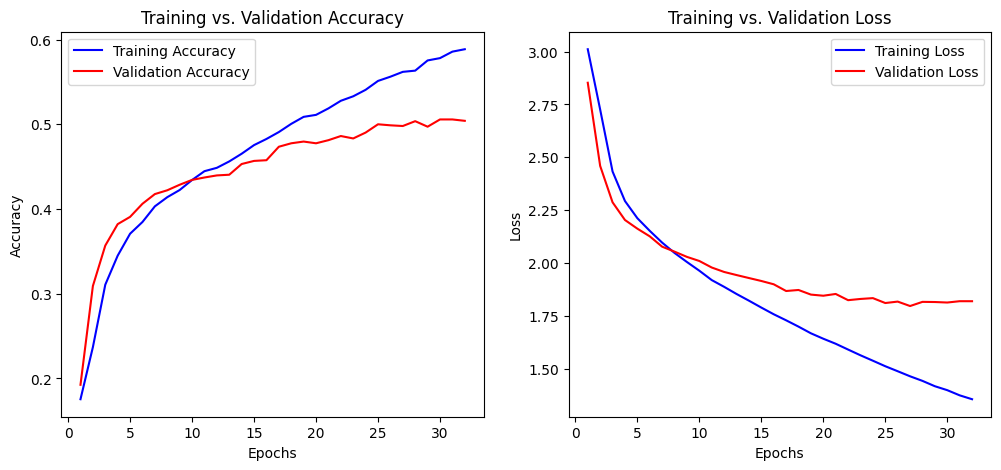

In [146]:
# Extract training history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs. Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')

plt.show()

## 9. Generate New Quotes



Generates a new quote by predicting the next words based on seed_text.

Parameters:
- seed_text (str): The initial text to start generating from.
- next_words (int): Number of words to generate.

Returns: 
- str: The generated quote.


In [147]:
# Step 9: Generate New Quotes
def generate_quote(seed_text, next_words=20):
    # Loop to generate 'next_words' number of words
    for _ in range(next_words):
        
        # Convert the input text into a sequence of token indices
        tokenized = tokenizer.texts_to_sequences([seed_text])[0]
        
        # Pad the sequence to match the expected input size of the model
        # Padding ensures the sequence is of the same length as used during training
        tokenized = pad_sequences([tokenized], maxlen=max_sequence_length-1, padding='pre')
        
        # Predict the next word using the trained model
        # np.argmax() gets the index of the highest probability word
        predicted = np.argmax(model.predict(tokenized, verbose=0), axis=-1)
        
        # Convert the predicted word index back to an actual word
        # If the word is not found, return an empty string to avoid errors
        word = tokenizer.index_word.get(predicted[0], '')

        # Append the predicted word to the seed text
        seed_text += " " + word

    # Return the final generated quote
    return seed_text

**Generate a random new quote**
- Select a random seed quote to give the model context to start from. 
- This is not necessary but encouraged as the model might make unpredictable things
    1.	If the words in seed_text exist in the vocabulary, the model treats it like any other input.
	2.	If the words are not in the vocabulary, they will be ignored or tokenized as Unknown (UNK).

In [153]:
random_quote = random.choice(quotes[:50])
# start_seed = random_quote
print(f"Selected Quote: {random_quote}")

Selected Quote: If you wanna make people dream, you’ve gotta start by believing in that dream yourself!


In [154]:
# Ask the user for input
# start_seed = input("Enter a starting phrase: ")

print("Generated Quote:")
print(generate_quote(random_quote, next_words=10))

Generated Quote:
If you wanna make people dream, you’ve gotta start by believing in that dream yourself!   b e v a n e v a n
